In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import powerlaw
import community as community_louvain
from fa2 import ForceAtlas2

For building the network, the relationships between the characters will be used, as created in the data building notebook. Moreover, in order to identify and keep only the most important characters, the characters dataframe is also loaded.

In [2]:
# Define the locations of the dataframes to be used in the analysis, ie. characters' names and relationships
tot_relationships_url = 'https://raw.githubusercontent.com/gpanagioto/projects_socialgraphs22/main/Project2/Relationships/total_relationships.csv'
characters_df_url = 'https://raw.githubusercontent.com/gpanagioto/projects_socialgraphs22/main/Project2/characters_df.csv'

# Load the dataframes
relationships_pd = pd.read_csv(tot_relationships_url, index_col=0)
characters_df = pd.read_csv(characters_df_url)

Now we can create a network by [using the relationship dataframe as edgelist](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html) and the weight as an edge attribute to show relationship strength:

In [3]:
G = nx.from_pandas_edgelist(relationships_pd,
                           source='source',
                           target='target',
                           edge_attr='weight',
                           create_using=nx.Graph())

Initial network statistics, number of nodes, edges, etc:

In [4]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 2732
Number of edges: 17175


### Connected component  

Since the graph is undirected, we use the function [`connected_components`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html)

In [5]:
Gcc = list( nx.connected_components(G))
Gcc = sorted(Gcc, key=len, reverse=True)
print(f"Number of connected components: {len(Gcc)}")

Number of connected components: 19


A number of connected components exist. Their size in regards to nodes is the following:

In [6]:
for i,  comp in enumerate(Gcc):
    print(f"Component {i}: {len(comp)}")    

Component 0: 2689
Component 1: 5
Component 2: 4
Component 3: 3
Component 4: 3
Component 5: 2
Component 6: 2
Component 7: 2
Component 8: 2
Component 9: 2
Component 10: 2
Component 11: 2
Component 12: 2
Component 13: 2
Component 14: 2
Component 15: 2
Component 16: 2
Component 17: 2
Component 18: 2


Since only the first component holds the vast majority of nodes, this is the network that is kept.

In [7]:
G = G.subgraph(Gcc[0])

### Centrality measures to decrease the number of nodes to the most important ones

This is a relatively large network, especially when trying to analyze interactions between characters. Not all of them are central to the plot. Some might be ancillary to the plot, or recurring. Some others might only be present to a couple or one episode. Obviously the latter are not valuable in the following analysis, since they are also bound to have low text content in their dialogues. Finally, there is the case of aggregated characters, like `Man`, `Woman`, `Officer` etc. While these generic names could have been removed during the character dataframe building phase, they are included to avoid biasing the analysis with prior knowledge of the show.

In [8]:
eigen_centr = nx.eigenvector_centrality(G)
closeness_centr = nx.closeness_centrality(G)
degree_centr = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

In [11]:
data = {'name': list(betweenness.keys()),
        'betweenness':list(betweenness.values()),
        'eigenvector':list(eigen_centr.values()),
        'degree': list(degree_centr.values()),
        'closeness':list(closeness_centr.values()),
       }

centralities_df = pd.DataFrame.from_dict(data)

The centrality measure used to remove some characters is betweenness centrality. Eigenvector centrality can favor cahracters not as important, but that have connected to major characters. First, the characters with betweenness centrality equal to $0$ are removed:

In [12]:
characters_reduced_df = centralities_df.loc[centralities_df.betweenness > 0]

Afterwards, the characters can be fiurther reduced by using selecting charactres that belong to the upper percentiles of the same centrality measure.

In [30]:
percentile = 50 # Percentile over which the characters are selected

cols = characters_reduced_df.columns
centralities_perc =  np.percentile( characters_reduced_df[cols[1]], percentile)

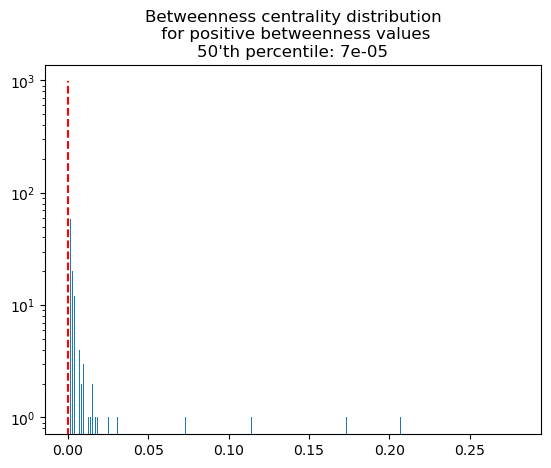

In [31]:
hist, edges = np.histogram( np.array(characters_reduced_df.betweenness.to_list()), bins = 200 )

plt.bar(edges[:-1], hist, width=0.0005)
plt.plot( [centralities_perc, centralities_perc], [0, hist.max()], 'r--' )
plt.yscale('log')
plt.title(f'Betweenness centrality distribution\n for positive betweenness values\n{percentile}\'th percentile: {np.round(centralities_perc, 5)}')
plt.show()

In [32]:
reduced_centralities_df = characters_reduced_df[ (characters_reduced_df[cols[1]] > centralities_perc)]

In [33]:
reduced_centralities_df.sort_values('betweenness', ascending=False)

,name,betweenness,eigenvector,degree,closeness
0,Cartman,0.281415,0.304051,0.488839,0.651952
2,Stan,0.207903,0.298978,0.452753,0.635912
1,Kyle,0.173543,0.289711,0.424479,0.623521
34,Randy,0.114574,0.184463,0.253720,0.557329
410,Butters,0.074043,0.171406,0.216146,0.543360
...,...,...,...,...,...
1556,CIA vice head,0.000069,0.012269,0.002976,0.424109
1167,Raisins girl,0.000069,0.019119,0.004836,0.436576
743,Autumn,0.000069,0.018282,0.005208,0.440367
582,People in Audience,0.000069,0.020522,0.007812,0.433129


Now save the reduced characteres list for further use:

In [34]:
reduced_centralities_df[['name']].to_csv('reduced_characters_df.csv', index=False)

### Create the network again using only the reduced characters list:

### Degree distribution

In [35]:
degrees_dist = np.array([ degree for (node, degree) in G.degree() ])

bins  = np.arange(degrees_dist.min(), degrees_dist.max()+1, 1)
hist, edges = np.histogram( degrees_dist, bins=bins )

A random network with the same probability and number of nodes with the south park network can be created for comparison:

In [36]:
N = G.number_of_nodes()
k_avg = degrees_dist.mean() # average degree

# probability p for E-R network
p = k_avg/(N-1)

# Generate directed ER network of same size and p 
G_er = nx.erdos_renyi_graph(n=N, p=p)

# Degree distribution for ER network
degrees_dist_er = np.array([deg for (node, deg) in G_er.degree()])

# Histogram for ER network
hist_er, edges_er = np.histogram(degrees_dist_er, bins=np.arange( degrees_dist_er.min(), degrees_dist_er.max()+1,1 ))

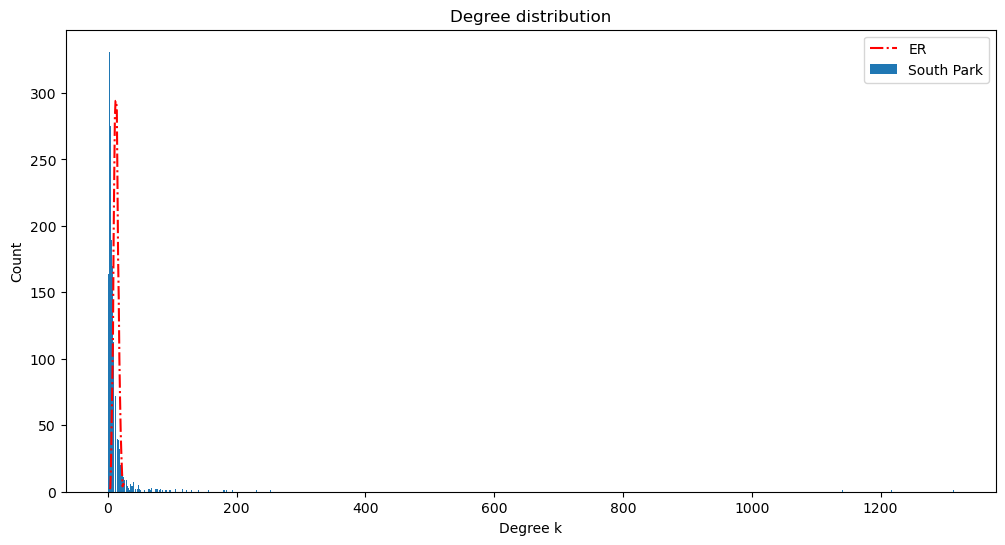

In [37]:
fig = plt.figure(figsize=(12,6))

plt.bar(edges[:-1], hist, width=0.8, label='South Park' )
plt.plot(edges_er[:-1], hist_er, 'r-.', label='ER')
plt.xlabel('Degree k')
plt.ylabel('Count')
plt.title('Degree distribution')


plt.legend()
plt.show()

Comparing the ER network with the South Park network, we can see that the later is a real world network, since it allows for large degrees and also that the majority of degrees are smaller in value than the average degree.

To get a better sense of the regime the network is in, we can plot the degree distribution in logarithmic scale. We also use the `powerlaw` library to estimate the degree exponent.

In [38]:
power_law_fit = powerlaw.Fit(degrees_dist)

degree_exponent = power_law_fit.alpha
print(f"The degree exponent is estimated: {np.round(degree_exponent,4)}")

The degree exponent is estimated: 2.6029


Calculating best minimal value for power law fit
C:\Users\user\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


Since the estimated degree exponent  has value $\gamma$: $2 < \gamma < 3$, the network is in the [scale-free regime](http://networksciencebook.com/chapter/4#degree-exponent). Large hubs are expected to exist, which decreases the distances between the nodes and the [Ultra-Small World](http://networksciencebook.com/chapter/4#ultra-small) phenomenon is observed.

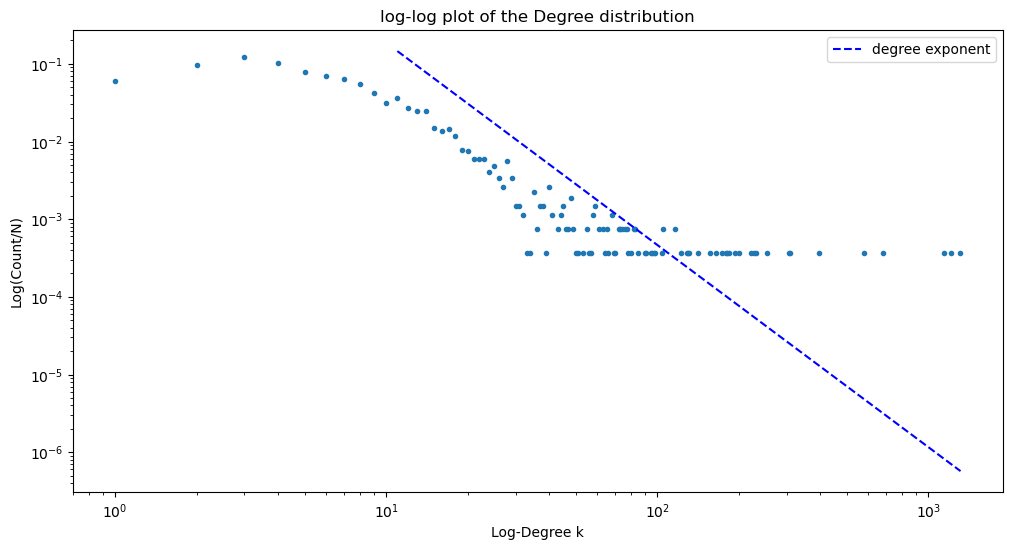

In [39]:
fig = plt.figure(figsize=(12,6))

plt.loglog(edges[:-1], hist/G.number_of_nodes(), '.' )
power_law_fit.power_law.plot_pdf(color= 'b',linestyle='--',label='degree exponent')

plt.xlabel('Log-Degree k')
plt.ylabel('Log(Count/N)')
plt.title('log-log plot of the Degree distribution')
plt.legend()

plt.show()

### Centrality measures

We can use centrality measures to find the most popular characters.

In [40]:
def plot_top_characters_centrality(centrality_dict, top_n):
    a = dict(sorted( centrality_dict.items(), key=lambda x: x[1], reverse=True )[:top_n])
    
    fig, ax = plt.subplots(1,1) 
    ax.bar(np.arange(len(list(a.values()))), list(a.values()))

    # Set number of ticks for x-axis
    ax.set_xticks( np.arange(len(list(a.keys()))) )
    # Set ticks labels for x-axis
    ax.set_xticklabels(list(a.keys()), rotation=60, fontsize=10)
    

In [41]:
# Top characters to show centralities
top_n = 10

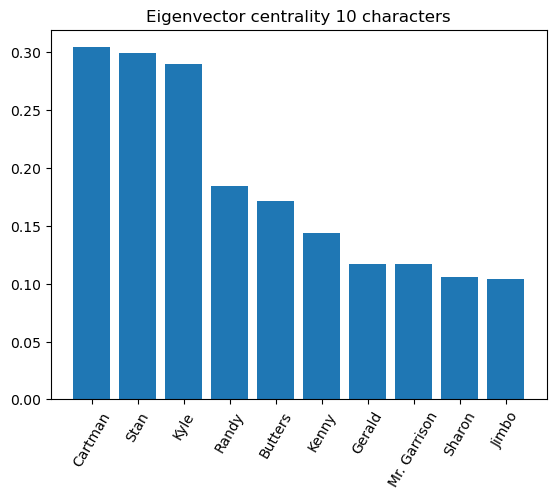

In [42]:
eigen_centr = nx.eigenvector_centrality(G)

plot_top_characters_centrality(eigen_centr, top_n)
plt.title(f'Eigenvector centrality {top_n} characters')
plt.show()

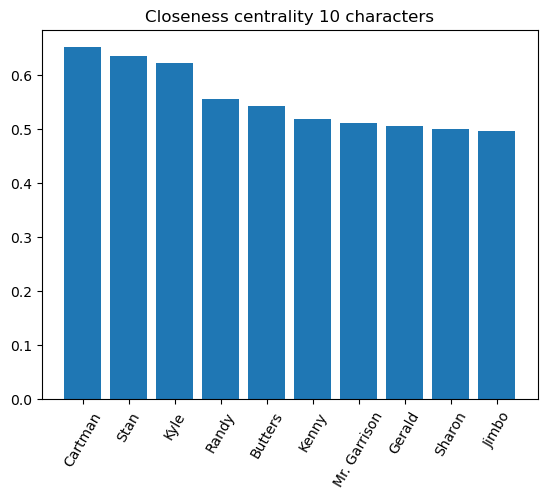

In [43]:
closeness_centr = nx.closeness_centrality(G)


plot_top_characters_centrality(closeness_centr, top_n)
plt.title(f'Closeness centrality {top_n} characters')
plt.show()

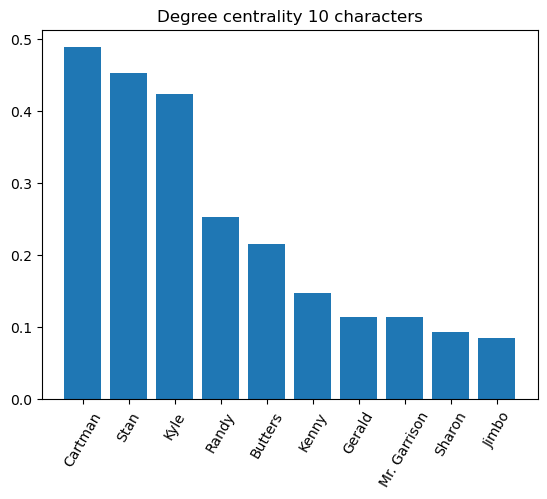

In [44]:
degree_centr = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centr, 'degree_centr')


plot_top_characters_centrality(degree_centr, top_n)
plt.title(f'Degree centrality {top_n} characters')
plt.show()

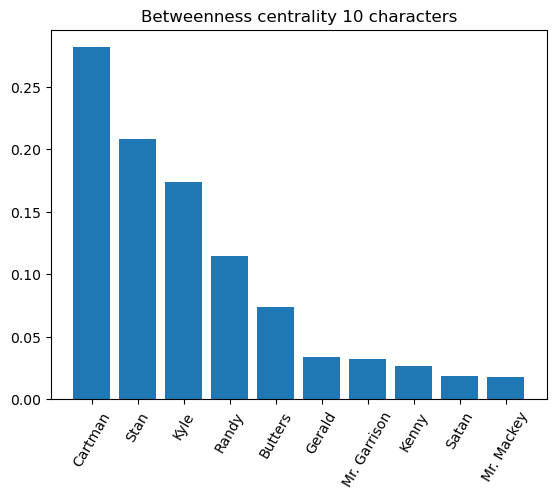

In [45]:
betweenness = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness, 'betweenness')

plot_top_characters_centrality(betweenness, top_n)
plt.title(f'Betweenness centrality {top_n} characters')
plt.show()

The top characters in regards to the centrality measures are very similar. The results are very familiar for someone who follows the series. However, the largest difference  is observed in the case of betweenness centrality. The top 3 characters there have much higher centrality than the rest.

### Community detection  

The `community` library is used here and the Louvain algorithm is used to find the communities by maximizing the modularity.

In [34]:
partitions = community_louvain.best_partition(G, random_state=1337)
print(f"{len(set(list(partitions.values())))} communities detected, with modularity {np.round(community_louvain.modularity(partitions, G),4)}")


42 communities detected, with modularity 0.2942


Modularity has a value of $\approx 0.29$, leading to the conclusion that the partitioning is [Suboptimal](http://networksciencebook.com/chapter/9#modularity). Not all the real communities are detected.

In addition, the community a character belongs to can be added as an attribute to the graph:

In [36]:
nx.set_node_attributes(G, partitions, 'community')

Create a dictionary that stores the communities as keys and the list of the characters it includes as values:

In [37]:
communities_dict = {i:[char for (char, comm) in partitions.items() if comm==i] for i in set(partitions.values())}

# Sort communities based on the number of members
communities_dict = dict( sorted( communities_dict.items(), key=lambda x: len(x[1]), reverse=True ) )

for community in list(communities_dict.keys()):
    print(f"Community {community} has {len(communities_dict[community])} members")

Community 0 has 611 members
Community 4 has 303 members
Community 3 has 235 members
Community 9 has 233 members
Community 15 has 220 members
Community 10 has 209 members
Community 25 has 192 members
Community 1 has 188 members
Community 7 has 178 members
Community 13 has 170 members
Community 22 has 136 members
Community 14 has 135 members
Community 20 has 134 members
Community 11 has 133 members
Community 24 has 81 members
Community 29 has 40 members
Community 23 has 38 members
Community 26 has 28 members
Community 37 has 23 members
Community 38 has 19 members
Community 32 has 13 members
Community 35 has 9 members
Community 31 has 8 members
Community 2 has 7 members
Community 39 has 7 members
Community 5 has 6 members
Community 16 has 6 members
Community 6 has 4 members
Community 12 has 4 members
Community 27 has 4 members
Community 40 has 4 members
Community 17 has 3 members
Community 19 has 3 members
Community 21 has 3 members
Community 28 has 3 members
Community 36 has 3 members
Co

In [42]:
# Keep the communities that have members higher than a certain percentile of the total members
percentile_to_keep = 25
perc = np.percentile(np.array([ len(x) for (comm,x) in communities_dict.items() ]), q=percentile_to_keep)

communities_dict_tmp = {}

for comm, members in communities_dict.items():
    if len(members) >= perc:
        communities_dict_tmp[comm] = members
        
communities_dict = communities_dict_tmp
del communities_dict_tmp

In [43]:
for community in list(communities_dict.keys()):
    print(f"Community {community} has {len(communities_dict[community])} members")

Community 0 has 611 members
Community 4 has 303 members
Community 3 has 235 members
Community 9 has 233 members
Community 15 has 220 members
Community 10 has 209 members
Community 25 has 192 members
Community 1 has 188 members
Community 7 has 178 members
Community 13 has 170 members
Community 22 has 136 members
Community 14 has 135 members
Community 20 has 134 members
Community 11 has 133 members
Community 24 has 81 members
Community 29 has 40 members
Community 23 has 38 members
Community 26 has 28 members
Community 37 has 23 members
Community 38 has 19 members
Community 32 has 13 members
Community 35 has 9 members
Community 31 has 8 members
Community 2 has 7 members
Community 39 has 7 members
Community 5 has 6 members
Community 16 has 6 members


We can also print some representative characters for each community:

In [45]:
communities_graphs_dict = {i:nx.subgraph(G, members) for i, members in communities_dict.items()}

n_repr = 7 # number of members to print
for community, members in communities_dict.items():
    comm_graph = communities_graphs_dict[community]
    top_deg_chars = {node: deg for node, deg in comm_graph.degree }
    top_deg_chars = list(dict(sorted( top_deg_chars.items(), key=lambda x: x[1], reverse=True )[:n_repr]).keys())
    print(f"Community {community}: {top_deg_chars}")

Community 0: ['Cartman', 'Stan', 'Kyle', 'Butters', 'Kenny', 'Liane', 'Clyde', 'Chef', 'Craig', 'Tolkien']
Community 4: ['Mr. Garrison', 'Mr. Mackey', 'PC Principal', 'Garrison', 'Principal Victoria', 'Mr. Slave', 'Mrs. Garrison', 'Mr. Hat', 'Strong Woman', 'Mr. Garrison Sr.']
Community 3: ['Jimbo', 'Ned', 'Mayor McDaniels', 'Tom', 'Mayor', 'Skeeter', 'Reporter', 'Officer Barbrady', 'Richard', 'Barbrady']
Community 9: ['Sharon', 'Kids', 'Mackey', 'Official', 'Judge', 'Goat', 'Expert 2', 'DiCaprio', 'Dr. Chinstrap', 'Volunteer 2']
Community 15: ['Stephen', 'Satan', 'Linda', 'Mark', 'Chris', 'Towelie', 'Gary', 'Thomas', 'Jenny', 'Mom']
Community 10: ['Man 2', 'Man 3', 'Man 4', 'Michael', 'Jesus', 'Narrator', 'Man 1', 'Man 8', 'Man 7', 'Woman 2']
Community 25: ['Jimmy', 'Timmy', 'Announcer', 'Nathan', 'Mimsy', 'Mr. Stevenson', 'Ryan', 'President Obama', 'Elon Musk', 'Agent']
Community 1: ['Gerald', 'Ike', 'Sheila', 'Dick', 'Anonymous821', 'Agent 2', 'MLKKK', 'Townsfolk', 'Townsman', 'Agen

### Assortativity   

With [assortativity](http://networksciencebook.com/chapter/7#introduction7) we can see if the hubs in the network tend to link to other hubs or prefer to link to low degree nodes. 

In [46]:
import networkx.algorithms as nx_alg

assort_coef = nx_alg.assortativity.degree_assortativity_coefficient(G)
print(f"Degree assortativity coefficient: {np.round(assort_coef,4)}")

Degree assortativity coefficient: -0.1764


Since the degree assortativity coefficient is negative , the network is  [disassortative](http://networksciencebook.com/chapter/7#measuring-degree), [also](https://en.wikipedia.org/wiki/Assortativity). Looks like the hubs avoid each other and prefer to link to lower degree nodes.  

We can repeat the experiment with the communities as attribute, asking the question: Do community members connect to each other or do they connect to members of different communities?

In [47]:
attr_assort_coef = nx_alg.assortativity.attribute_assortativity_coefficient(G, 'community')
print(f"Attribute (community) assortativity coefficient: {np.round(attr_assort_coef,4)}")

Attribute (community) assortativity coefficient: 0.398


In the case of communities, it seems the members of each community tend to connect to each other. This coefficient shows an assortative network. However, the value of the coefficinet is  positive, but not very close to 1.

### Visualization of the network  

With the detected communities, and using the edge attribute weight, we can plot a visualization of the network using the `ForceAtlas2` library.

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:26<00:00, 190.70it/s]


BarnesHut Approximation  took  3.23  seconds
Repulsion forces  took  19.52  seconds
Gravitational forces  took  0.16  seconds
Attraction forces  took  1.98  seconds
AdjustSpeedAndApplyForces step  took  0.59  seconds


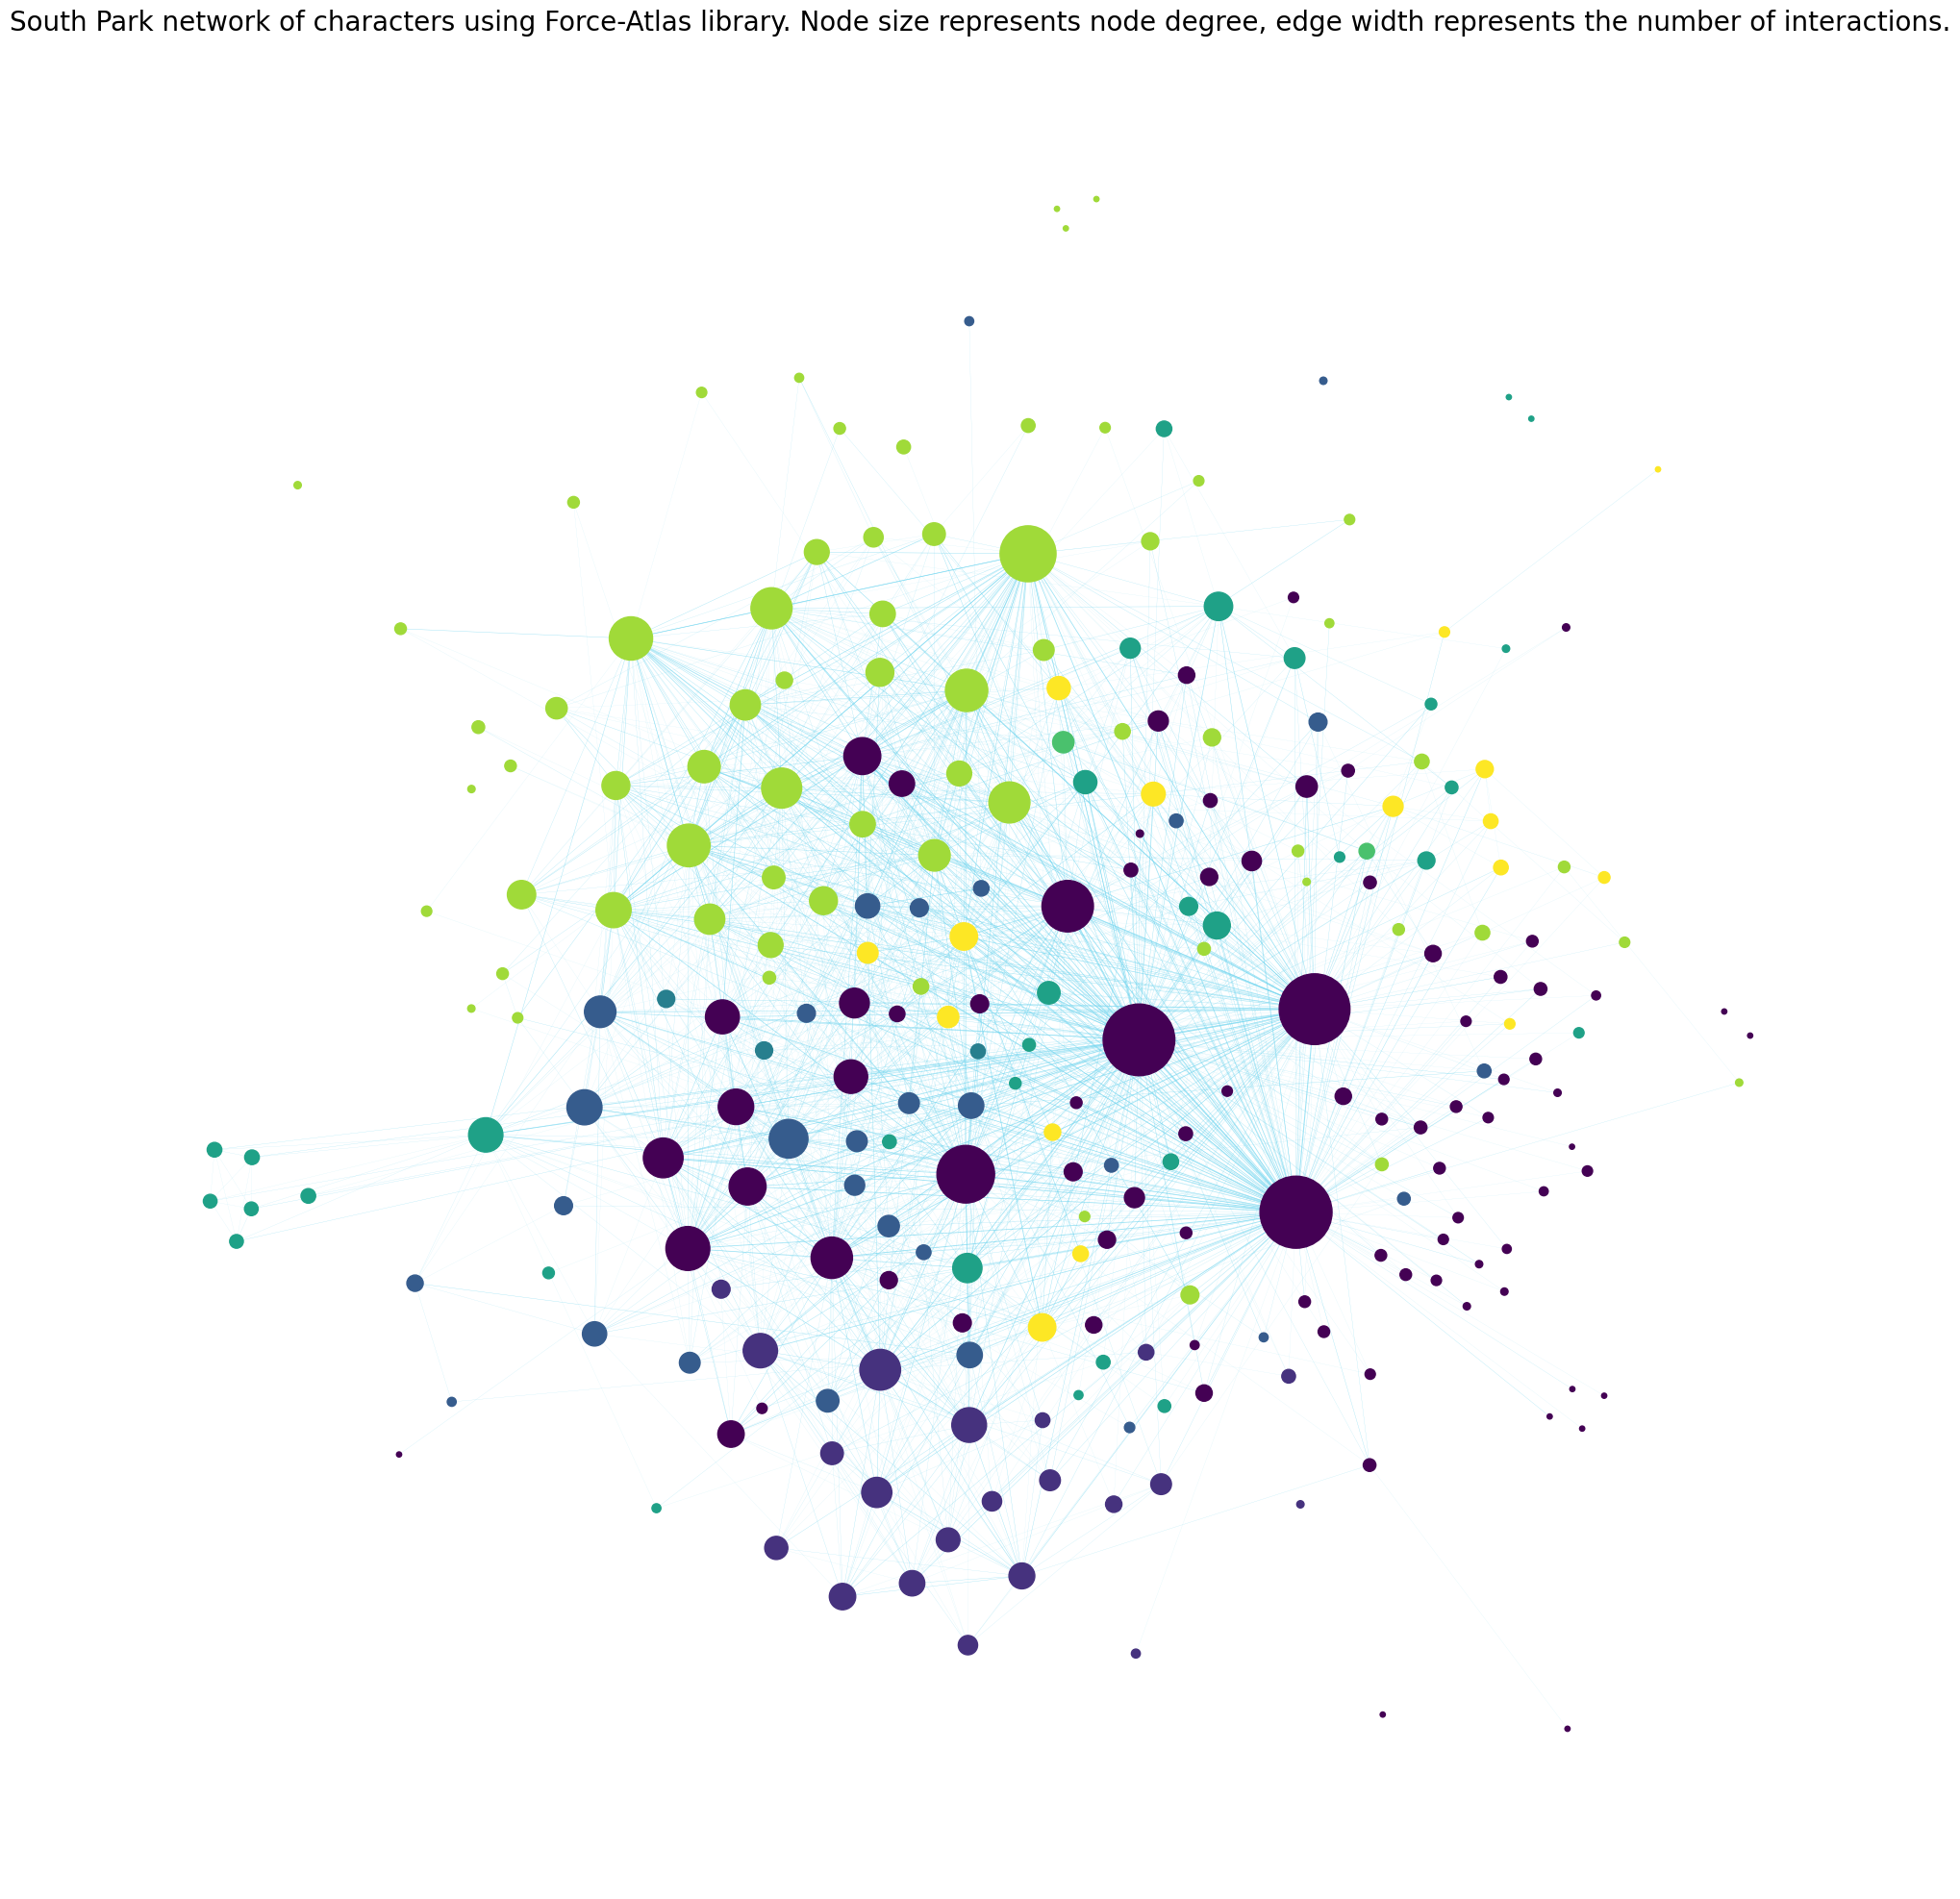

In [104]:
# Visulization of the network
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0.1*1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=30.0,
                        strongGravityMode=False,
                        gravity=20.0,

                        # Log
                        verbose=True)

node_options = {
    # Setting node size based on degree
    'node_size' : [degree*15 for degree in degrees_dist],
    
    # Setting the node color based on the community it belongs to
    'node_color' :  list(partitions.values()),
    
    'alpha': 1
}



edges_options = {
    # Edge colors based on communities
    'width' : [ np.log(data["weight"])*0.1 for source, target, data in  G.edges(data=True)],
    'edge_color': '#71d6f0',
    'alpha': 0.68,
}



fig = plt.figure(figsize = [25, 25])
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)
nx.draw_networkx_nodes(G, positions, **node_options)
nx.draw_networkx_edges(G, positions, **edges_options)
plt.axis('off')

# # Indicating node colors
# y = 0.88 # This is the starting y position for the figure legend
# plt.figtext(1, y, 'Node colors:', size = 17, color = 'black')
# colots_node = ['green','red','purple']
# role_node = ['ally', 'enemy','boss']
# y -= 0.03
# for i in range(3):
#     plt.figtext(1, y, str(role_node[i]), size = 17, color = colots_node[i])
#     y -= 0.03

plt.title("South Park network of characters using Force-Atlas library. Node size represents node degree, edge width represents the number of interactions.", fontsize=20)
plt.show()